Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [116]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import PIL
import PIL.Image
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom , RandomBrightness
from keras.callbacks import EarlyStopping




In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Changing path to dataset directory
cd 'gdrive/My Drive/CNNAssignment'

/content/gdrive/My Drive/CNNAssignment


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path("Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing


Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)  ##todo

Found 2689 files belonging to 9 classes.
Using 2152 files for training.


In [9]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)##todo

Found 2689 files belonging to 9 classes.
Using 537 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
num_classes = len(class_names)

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

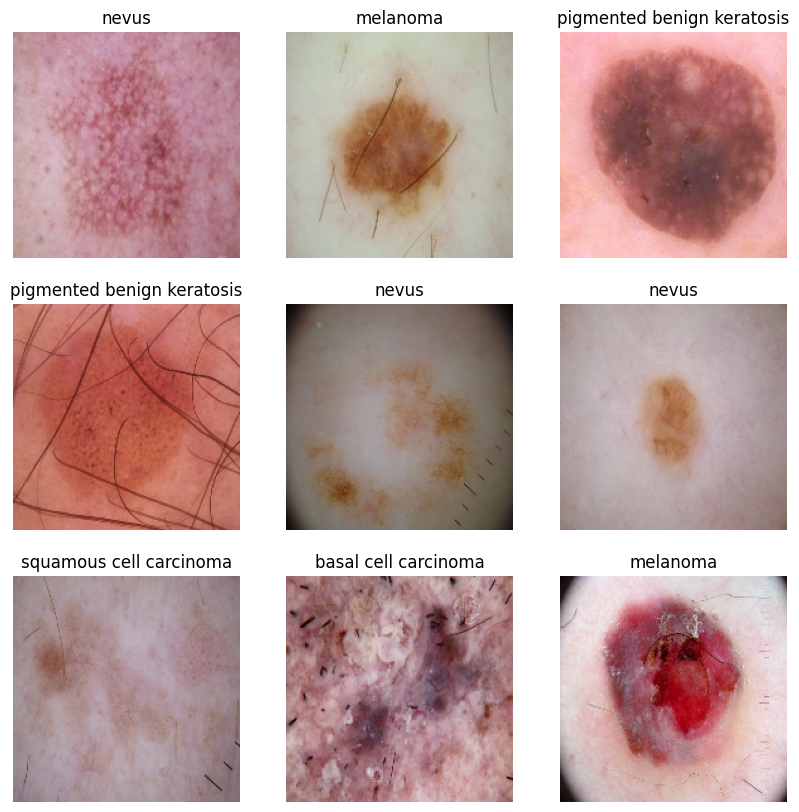

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
image_batch.shape[1:]

TensorShape([180, 180, 3])

In [181]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5, # Number of epochs with no improvement before stopping
    mode="auto",
    verbose=1,
    restore_best_weights=True  # Restore the best model weights
)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:

### Your code goes here
# The Rescaling layer is now directly available in tf.keras.layers
normalization_layer = Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:

# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=image_batch.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,319,881 (27.92 MB)

 Trainable params: 7,319,881 (27.92 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.2326 - loss: 78.7324 - val_accuracy: 0.4320 - val_loss: 1.8528
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.3608 - loss: 1.8339 - val_accuracy: 0.3631 - val_loss: 1.7147
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4178 - loss: 1.5904 - val_accuracy: 0.4153 - val_loss: 1.7673
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4630 - loss: 1.5962 - val_accuracy: 0.4860 - val_loss: 1.8967
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5058 - loss: 1.4086 - val_accuracy: 0.4432 - val_loss: 1.8039
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4717 - loss: 1.6720 - val_accuracy: 0.3929 - val_loss: 1.9179
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4837 - loss: 1.4652 - val_accuracy: 0.4693 - val_loss: 1.8309
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5280 - loss: 1.3578 - val_accuracy: 0.4246 -

### Visualizing training results

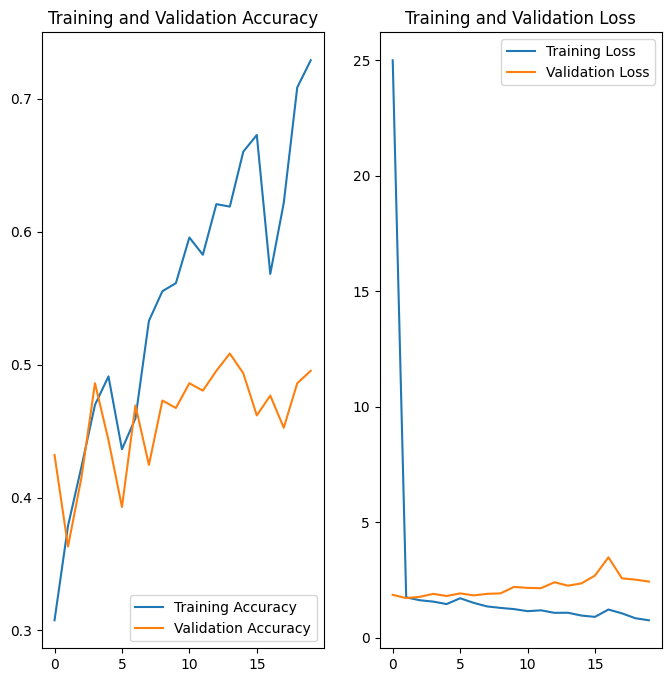

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Found model validation acuracy is lower than training accuracy by big margin so it appears model is overfit hence need to use data augmentation strategy.

In [23]:
# Extract images and labels from train_ds
images = []
labels = []
for img_batch, label_batch in train_ds:
    images.append(img_batch)
    labels.append(label_batch)

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2)
])



In [25]:
# Apply data augmentation to the images
augmented_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

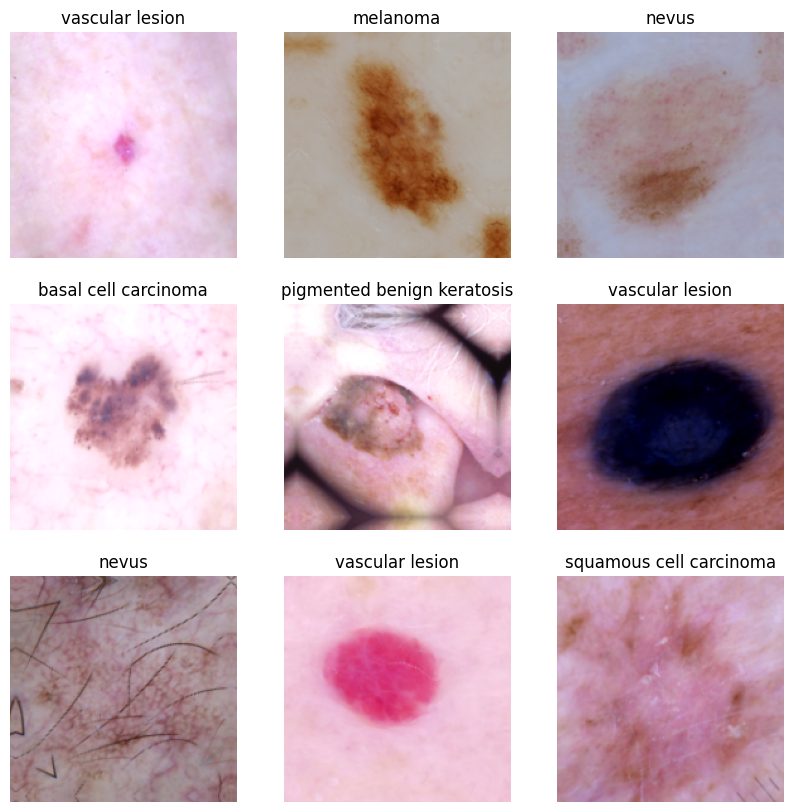

In [26]:
plt.figure(figsize=(10, 10))
for images1, labels1 in augmented_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images1[i].numpy().astype("uint8"))
    plt.title(class_names[labels1[i]])
    plt.axis("off")

In [27]:
# Add caching, shuffling, and prefetching
final_augmented_train_ds = augmented_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [28]:
for image_batch1, labels_batch1 in final_augmented_train_ds:
  print(image_batch1.shape)
  print(labels_batch1.shape)
  break

(32, 180, 180, 3)
(32,)


In [29]:
image_batch1.shape[1:]

TensorShape([180, 180, 3])

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# model architecture

# model architecture
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=image_batch.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,319,881 (27.92 MB)

 Trainable params: 7,319,881 (27.92 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
## Your code goes here, note: train your model for 20 epochs
## your training code

epochs = 20
history = model1.fit(
  final_augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2179 - loss: 50.3427 - val_accuracy: 0.3501 - val_loss: 1.8798
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3347 - loss: 1.9445 - val_accuracy: 0.3426 - val_loss: 1.8216
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3866 - loss: 1.7536 - val_accuracy: 0.3613 - val_loss: 1.8079
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4089 - loss: 1.6575 - val_accuracy: 0.2384 - val_loss: 6.4225
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3463 - loss: 2.0552 - val_accuracy: 0.3445 - val_loss: 1.8133
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4350 - loss: 1.5359 - val_accuracy: 0.3501 - val_loss: 1.9288
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4414 - loss: 1.5115 - val_accuracy: 0.4041 - val_loss: 1.8644
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4886 - loss: 1.3763 - val_accuracy: 0.3631 - 

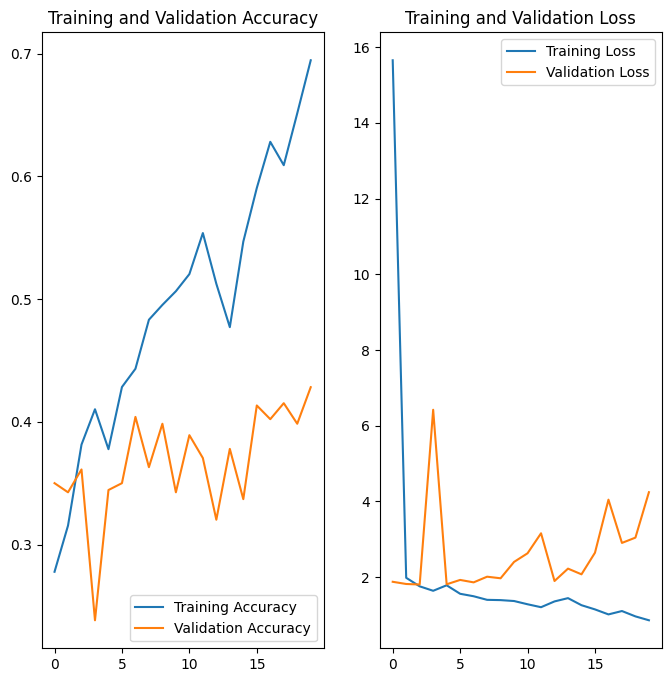

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
## Addng Dropout layer
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# model architecture
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=image_batch.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))


model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))





/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [57]:
## Your code goes here
model3.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_39 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,319,881 (27.92 MB)

 Trainable params: 7,319,881 (27.92 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [59]:
## Your code goes here, note: train your model for 20 epochs
## your training code

epochs = 20
history = model3.fit(
  final_augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.2211 - loss: 39.9065 - val_accuracy: 0.4413 - val_loss: 1.6081
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4212 - loss: 1.6610 - val_accuracy: 0.5028 - val_loss: 1.5144
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4951 - loss: 1.4499 - val_accuracy: 0.4115 - val_loss: 1.7868
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4648 - loss: 1.6523 - val_accuracy: 0.4991 - val_loss: 1.5322
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4828 - loss: 1.4819 - val_accuracy: 0.5028 - val_loss: 1.4654
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5149 - loss: 1.4487 - val_accuracy: 0.3296 - val_loss: 1.7716
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3699 - loss: 1.7505 - val_accuracy: 0.4618 - val_loss: 1.7275
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4560 - loss: 1.5105 - val_accuracy: 0.4823 - 

### Visualizing the results

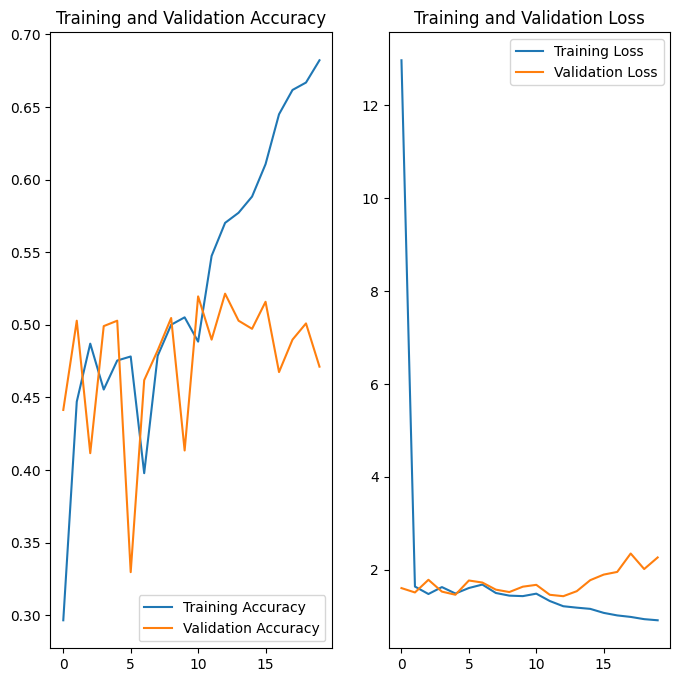

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

###### observed little improvement in terms of overfitting issue from previous model as train accuracy vs Validation accuracy gap reduced but  still validation score is low which could be due to class imbalence.lets check that now.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count('Train')

In [ ]:
df

,Class,No. of Image
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,pigmented benign keratosis,462
3,melanoma,438
4,dermatofibroma,95
5,nevus,357
6,vascular lesion,139
7,seborrheic keratosis,77
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

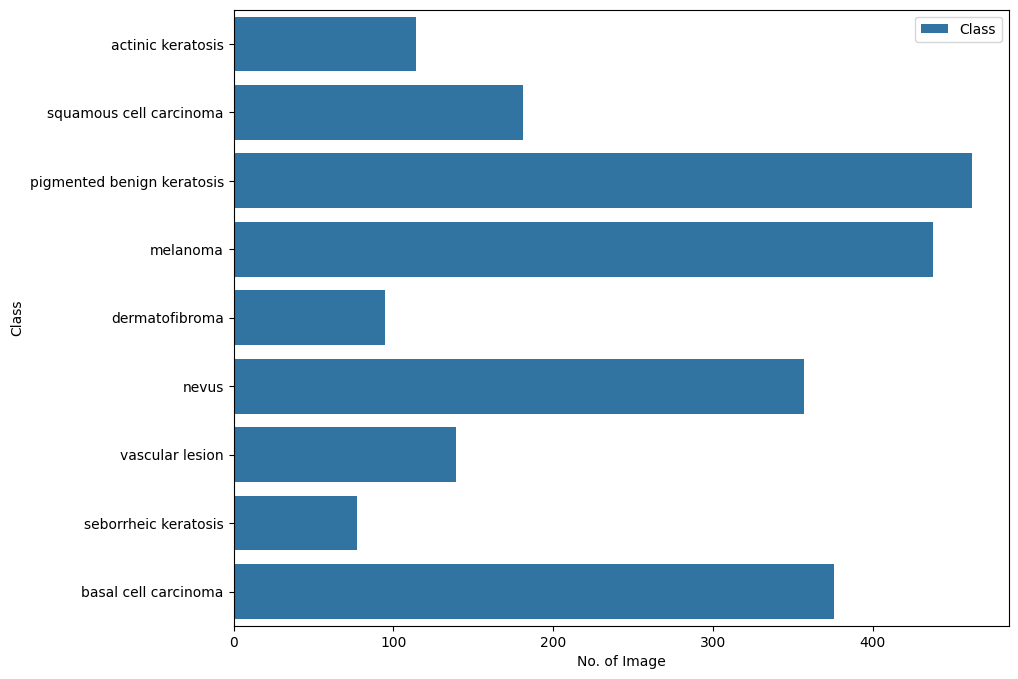

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
- seborrheic keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis
- melanoma
- nevus
- basal cell carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

In [ ]:
pwd

'/content/gdrive/MyDrive/CNNAssignment'

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNNAssignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0458C1F400>: 100%|██████████| 500/500 [00:04<00:00, 106.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C047071DE40>: 100%|██████████| 500/500 [00:04<00:00, 106.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C04AD3B9F00>: 100%|██████████| 500/500 [00:04<00:00, 107.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C04707B7640>: 100%|██████████| 500/500 [00:13<00:00, 36.38 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7C047071D780>: 100%|██████████| 500/500 [00:13<00:00, 37.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C04F02B3D00>: 100%|██████████| 500/500 [00:04<00:00, 109.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C0458B3BCD0>: 100%|██████████| 500/500 [00:07<00:00, 68.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C047064D150>: 100%|██████████| 500/500 [00:04<00:00, 106.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNNAssignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C04700C20E0>: 100%|██████████| 500/500 [00:04<00:00, 107.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_d7b6719b-1c42-462b-a096-1b5ad0e43592.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_fd804c30-cc82-419f-bc34-6142ac06c826.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_5e6974c6-0701-4a15-bcea-b558e5014d37.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_5f4e7402-8242-4148-8f53-03fbe6bf4e62.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_67ec2a35-f69c-403b-b849-b226065e5d76.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_94e4c029-eafc-4caf-af33-3992e628e53b.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_6c5562c4-cefe-4e79-9f6e-4168418ada41.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_4029c07f-e0a2-46d1-b5e5-c06cf7f3d812.jpg',
 'Train/actinic keratosis/output/actinic

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
new_df = df2

In [ ]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
squamous cell carcinoma,500
pigmented benign keratosis,500
melanoma,500
dermatofibroma,500
nevus,500
vascular lesion,500
seborrheic keratosis,500
basal cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [2]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [3]:
data_dir_train="/content/gdrive/MyDrive/CNNAssignment/Augmented"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
## Write your train dataset here
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [6]:
num_classes = len(class_names)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### **Todo:** Create your model (make sure to include normalization)

In [9]:
## your code goes here
normalization_layer = Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [66]:
## Addng Dropout layer
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# model architecture
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same',input_shape=image_batch.shape[1:]))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))


model5.add(Conv2D(64, (3, 3), padding='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())
model5.add(Dense(128))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))
model5.add(Dense(num_classes))
model5.add(Activation('softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
model5.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
model5.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_46 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,319,881 (27.92 MB)

 Trainable params: 7,319,881 (27.92 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [69]:
## Your code goes here, use 50 epochs.
epochs = 30
history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.2847 - loss: 63.2388 - val_accuracy: 0.4302 - val_loss: 1.7211
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4546 - loss: 1.5924 - val_accuracy: 0.3985 - val_loss: 1.7728
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3625 - loss: 2.2417 - val_accuracy: 0.3873 - val_loss: 1.7428
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4450 - loss: 1.6333 - val_accuracy: 0.4525 - val_loss: 1.6583
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4783 - loss: 1.5427 - val_accuracy: 0.5121 - val_loss: 1.6548
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4996 - loss: 1.4776 - val_accuracy: 0.5102 - val_loss: 1.5534
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5034 - loss: 1.4170 - val_accuracy: 0.5009 - val_loss: 1.5450
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5461 - loss: 1.3113 - val_accuracy: 0.5270 - 

#### **Todo:**  Visualize the model results

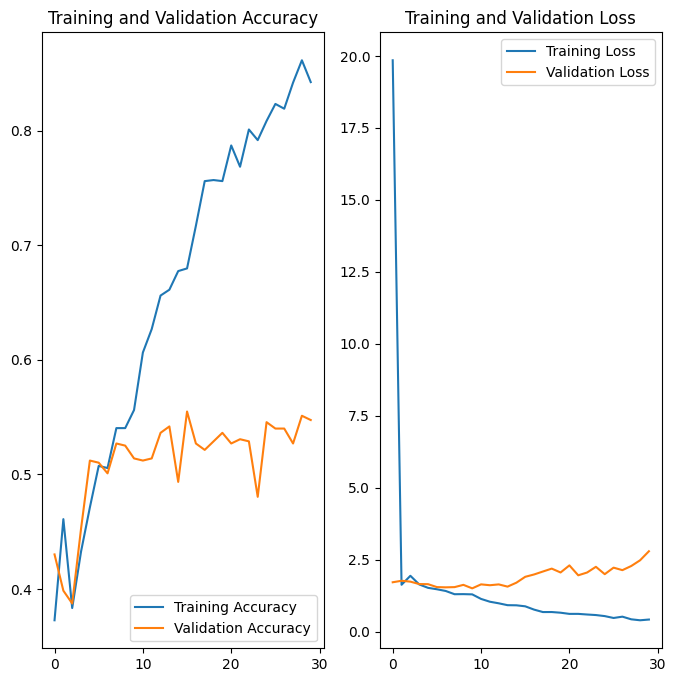

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Adding batch normalization and changing model architecture to reduce overfitting and improve performance . Adding mre dropout and dense layer neuron count.

In [183]:
## Addng Dropout layer and changing to smaller dense layer
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

# model architecture
model28= Sequential()
model28.add(Conv2D(32, (3, 3), padding='same',input_shape=image_batch.shape[1:]))
model28.add(Activation('relu'))
model28.add(BatchNormalization())
model28.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model28.add(Conv2D(64, (3, 3), padding='same'))
model28.add(Activation('relu'))
model28.add(BatchNormalization())
model28.add(MaxPooling2D(pool_size=(2, 2)))

model28.add(Conv2D(128, (3, 3)))
model28.add(Activation('relu'))
model28.add(BatchNormalization())
model28.add(MaxPooling2D(pool_size=(2, 2)))
model28.add(Dropout(0.15))

model28.add(Flatten())
model28.add(Dense(512))
model28.add(Activation('relu'))
model28.add(Dropout(0.30))
model28.add(Dense(num_classes))
model28.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

We got rid of overfitting to sme extent

In [184]:
## your code goes here
model28.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [185]:
model28.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)                  │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_175 (Activation)          │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_105 (MaxPooling2D)     │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_176 (Activation)          │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_106 (MaxPooling2D)     │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_177 (Activation)          │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_107 (MaxPooling2D)     │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 512)                 │      28,901,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_178 (Activation)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_179 (Activation)          │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,000,649 (110.63 MB)

 Trainable params: 29,000,201 (110.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [186]:
## Your code goes here, use 30 epochs.
# Restoring model weights from the end of the best epoc
epochs = 30
history = model28.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.3443 - loss: 11.9505 - val_accuracy: 0.1769 - val_loss: 2.8210
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4355 - loss: 1.7161 - val_accuracy: 0.4339 - val_loss: 1.6277
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5136 - loss: 1.3775 - val_accuracy: 0.5233 - val_loss: 1.3597
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5470 - loss: 1.3528 - val_accuracy: 0.5307 - val_loss: 1.5016
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5853 - loss: 1.2078 - val_accuracy: 0.5065 - val_loss: 1.5044
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5874 - loss: 1.1080 - val_accuracy: 0.5009 - val_loss: 1.4803
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5823 - loss: 1.1496 - val_accuracy: 0.5810 - val_loss: 1.2158
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5985 - loss: 1.0337 - val_accuracy: 0.5624 

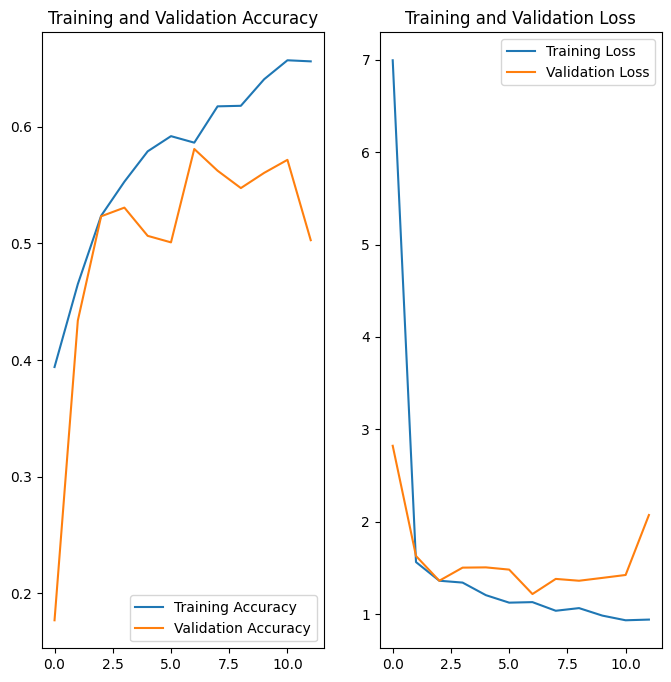

In [190]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Update: Set the range using the length of training history data
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()